# OOD detection and Class Activation Maps Demo

Add utils to sys to import our custom scripts

In [1]:
import os
import sys
# Go up one level from 'examples' and point to 'utils' folder
utils_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'utils'))
# Add the 'utils' folder to sys.path
sys.path.append(utils_path)
models_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'example_data'))
# Add the 'models' folder to sys.path
sys.path.append(models_path)

import utils.data_utils as data_utils
from utils.model_selector import model_selector
import numpy as np
import matplotlib.pyplot as plt
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
device = "cuda" if torch.cuda.is_available() == True else "cpu"

First, we load the example data (all data from our article is availabel via Zenodo: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15460140.svg)](https://doi.org/10.5281/zenodo.15460140) )

In [3]:
labels = {0:"VT",1:"LP",2:"TR",3:"NO",4:"AV",5:"TC"}
example_data = []
true_labels = []
for path in os.listdir("example_data"):
    example_data.append(np.load(f"example_data/{path}"))
    true_labels.append(path[:2])

We can obtain each representation with the *obtain_rep()* function

In [4]:
idx = 5
rep1 = data_utils.obtain_rep(example_data[idx],type_rep=1)
rep2 = data_utils.obtain_rep(example_data[idx],type_rep=2)
rep3 = data_utils.obtain_rep(example_data[idx],type_rep=3)
rep4 = data_utils.obtain_rep(example_data[idx],type_rep=4)
true_label = true_labels[idx]

Representation 1

In [5]:
%matplotlib inline

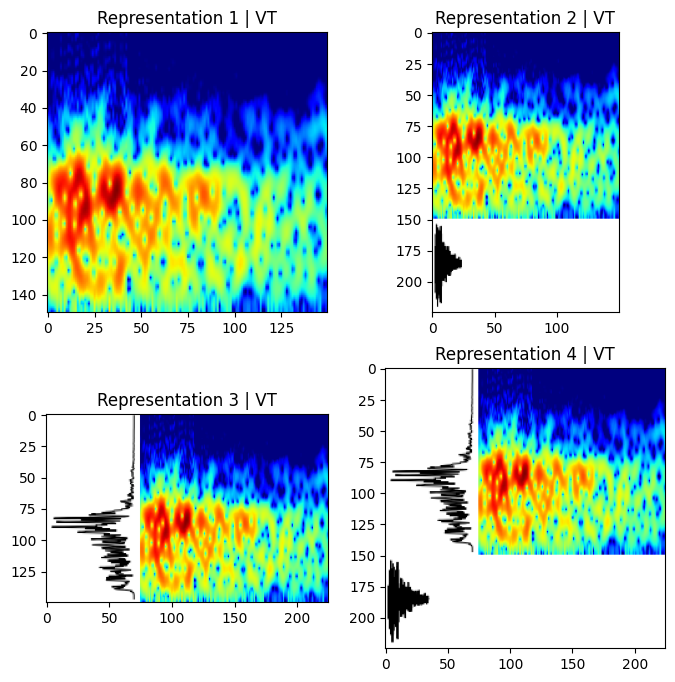

In [6]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
axes[0,0].imshow(rep1)
axes[0,1].imshow(rep2)
axes[1,0].imshow(rep3)
axes[1,1].imshow(rep4)
axes[0,0].set_title(f"Representation 1 | {true_label}")
axes[0,1].set_title(f"Representation 2 | {true_label}")
axes[1,0].set_title(f"Representation 3 | {true_label}")
axes[1,1].set_title(f"Representation 4 | {true_label}")
plt.show()

We test each representation, for this we have to select the model and download the corresponding weights and OOD detectors:

### Representation 1 - Spectrogram

In [7]:
model, OOD_detector = model_selector("rep_1") 
_ = model.eval()

Weights already downloaded at rep1_best_model.pt
OOD already downloaded at OOD_detector_rep1.pkl
Loading weights and OOD detector...
Model weigths successfully loaded...


We create a batch with all 6 example traces

In [8]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
batch = []
for trace in example_data:
    X = data_utils.obtain_rep(trace, 1)
    X = transform(X.copy())
    batch.append(X)
batch = np.array(batch)
batch = torch.tensor(batch.copy()).to(device)

And pass it through our model

In [9]:
outputs = model(batch).detach().cpu().numpy()
feats = model.features(batch)
flatten_feats = feats.view(feats.shape[0], -1).detach().cpu()
KNN_scores = OOD_detector.score(features=flatten_feats)
predicted = outputs.argmax(1)

print("True | Predicted | OOD/Confidence Score:")
for idx, pred_score in enumerate(zip(predicted, KNN_scores)):
    print(true_labels[idx], "        ",labels[pred_score[0]], "        ", pred_score[1])

True | Predicted | OOD/Confidence Score:
AV          LP          0.0049233013
LP          LP          0.0050681033
NO          LP          0.004613848
TC          TR          0.0051483684
TR          TR          0.0054112147
VT          VT          0.00465965


We can Visualize Class Activation Maps:

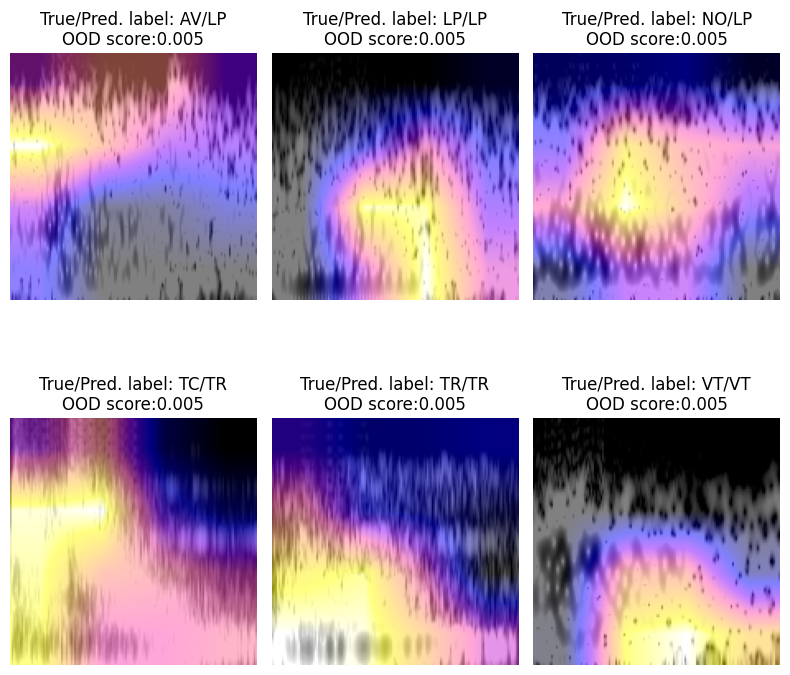

In [10]:
fig, axes = plt.subplots(2,3,figsize=(8,8))
for idx, pred in enumerate(predicted):
    i, j = divmod(idx, 3)
    target_layers = [model.features[43]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred)]
    grayscale_cam = cam(input_tensor=batch[idx].unsqueeze(0), targets=targets)
    cam_ = grayscale_cam[0, :]
    example_img = batch[idx].detach().cpu().numpy().transpose(1, 2, 0)
    example_img = np.mean(example_img, axis=2)
    example_img -= example_img.min()
    example_img /= example_img.max()
    example_img *= 255
    axes[i,j].imshow(example_img, cmap="gray")
    axes[i,j].imshow(cam_, cmap="gnuplot2", alpha=0.5)
    # plt.title(f"{context} | {correctness} | {clase_plot}")
    axes[i,j].axis("off")
    axes[i,j].set_title(f"True/Pred. label: {true_labels[idx]}/{labels[pred]}\nOOD score:{KNN_scores[idx]:.3f}")
plt.tight_layout()
    

### Representation 2 - Spectrogram + Waveform

In [11]:
model, OOD_detector = model_selector("rep_2") 
_ = model.eval()

Weights already downloaded at rep2_best_model.pt
OOD already downloaded at OOD_detector_rep2.pkl
Loading weights and OOD detector...
Model weigths successfully loaded...


We create a batch with all 6 example traces

In [12]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
batch = []
for trace in example_data:
    X = data_utils.obtain_rep(trace, 2)
    X = transform(X.copy())
    batch.append(X)
batch = np.array(batch)
batch = torch.tensor(batch.copy()).to(device)

And pass it through our model

In [13]:
outputs = model(batch).detach().cpu().numpy()
feats = model.features(batch)
flatten_feats = feats.view(feats.shape[0], -1).detach().cpu()
KNN_scores = OOD_detector.score(features=flatten_feats)
predicted = outputs.argmax(1)

print("True | Predicted | OOD/Confidence Score:")
for idx, pred_score in enumerate(zip(predicted, KNN_scores)):
    print(true_labels[idx], "        ",labels[pred_score[0]], "        ", pred_score[1])

True | Predicted | OOD/Confidence Score:
AV          LP          0.29432437
LP          LP          0.33676305
NO          LP          0.24539651
TC          TR          0.23090678
TR          TR          0.41893414
VT          VT          0.40590099


We can Visualize Class Activation Maps:

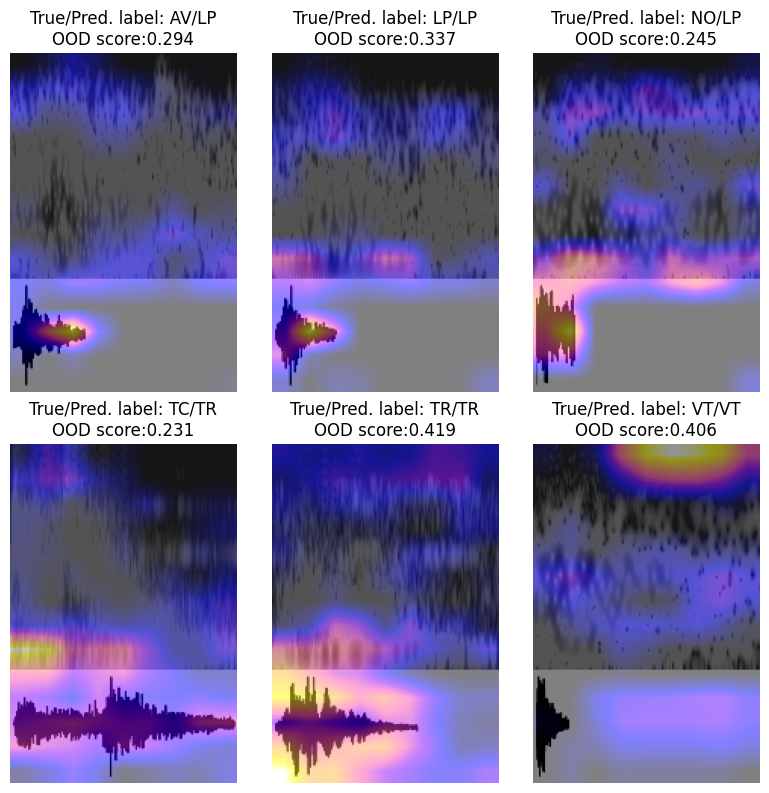

In [14]:
fig, axes = plt.subplots(2,3,figsize=(8,8))
for idx, pred in enumerate(predicted):
    i, j = divmod(idx, 3)
    target_layers = [model.features[43]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred)]
    grayscale_cam = cam(input_tensor=batch[idx].unsqueeze(0), targets=targets)
    cam_ = grayscale_cam[0, :]
    example_img = batch[idx].detach().cpu().numpy().transpose(1, 2, 0)
    example_img = np.mean(example_img, axis=2)
    example_img -= example_img.min()
    example_img /= example_img.max()
    example_img *= 255
    axes[i,j].imshow(example_img, cmap="gray")
    axes[i,j].imshow(cam_, cmap="gnuplot2", alpha=0.5)
    # plt.title(f"{context} | {correctness} | {clase_plot}")
    axes[i,j].axis("off")
    axes[i,j].set_title(f"True/Pred. label: {true_labels[idx]}/{labels[pred]}\nOOD score:{KNN_scores[idx]:.3f}")
plt.tight_layout()
    

### Representation 3 - Spectrogram + Spectrum

In [15]:
model, OOD_detector = model_selector("rep_3") 
_ = model.eval()

Weights already downloaded at rep3_best_model.pt
OOD already downloaded at OOD_detector_rep3.pkl
Loading weights and OOD detector...
Model weigths successfully loaded...


We create a batch with all 6 example traces

In [16]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
batch = []
for trace in example_data:
    X = data_utils.obtain_rep(trace, 3)
    X = transform(X.copy())
    batch.append(X)
batch = np.array(batch)
batch = torch.tensor(batch.copy()).to(device)

And pass it through our model

In [17]:
outputs = model(batch).detach().cpu().numpy()
feats = model.features(batch)
flatten_feats = feats.view(feats.shape[0], -1).detach().cpu()
KNN_scores = OOD_detector.score(features=flatten_feats)
predicted = outputs.argmax(1)

print("True | Predicted | OOD/Confidence Score:")
for idx, pred_score in enumerate(zip(predicted, KNN_scores)):
    print(true_labels[idx], "        ",labels[pred_score[0]], "        ", pred_score[1])

True | Predicted | OOD/Confidence Score:
AV          VT          0.08232656
LP          LP          0.37646863
NO          LP          0.2513639
TC          TR          0.2639026
TR          TR          0.33391574
VT          VT          0.60176617


We can Visualize Class Activation Maps:

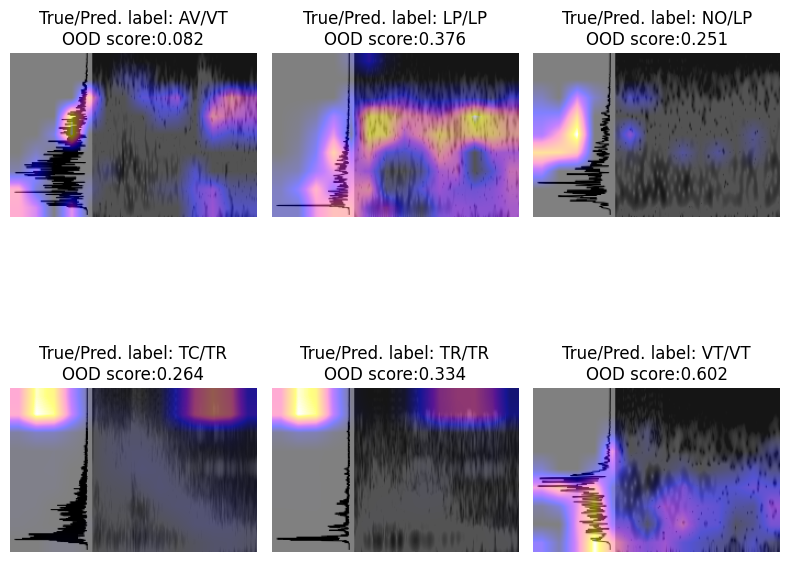

In [18]:
fig, axes = plt.subplots(2,3,figsize=(8,8))
for idx, pred in enumerate(predicted):
    i, j = divmod(idx, 3)
    target_layers = [model.features[43]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred)]
    grayscale_cam = cam(input_tensor=batch[idx].unsqueeze(0), targets=targets)
    cam_ = grayscale_cam[0, :]
    example_img = batch[idx].detach().cpu().numpy().transpose(1, 2, 0)
    example_img = np.mean(example_img, axis=2)
    example_img -= example_img.min()
    example_img /= example_img.max()
    example_img *= 255
    axes[i,j].imshow(example_img, cmap="gray")
    axes[i,j].imshow(cam_, cmap="gnuplot2", alpha=0.5)
    # plt.title(f"{context} | {correctness} | {clase_plot}")
    axes[i,j].axis("off")
    axes[i,j].set_title(f"True/Pred. label: {true_labels[idx]}/{labels[pred]}\nOOD score:{KNN_scores[idx]:.3f}")
plt.tight_layout()
    

### Representation 4 - Spectrogram + Waveform + Spectrum

In [19]:
model, OOD_detector = model_selector("rep_4") 
_ = model.eval()

Weights already downloaded at rep4_best_model.pt
OOD already downloaded at OOD_detector_rep4.pkl
Loading weights and OOD detector...
Model weigths successfully loaded...


We create a batch with all 6 example traces

In [20]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
batch = []
for trace in example_data:
    X = data_utils.obtain_rep(trace, 4)
    X = transform(X.copy())
    batch.append(X)
batch = np.array(batch)
batch = torch.tensor(batch.copy()).to(device)

And pass it through our model

In [21]:
outputs = model(batch).detach().cpu().numpy()
feats = model.features(batch)
flatten_feats = feats.view(feats.shape[0], -1).detach().cpu()
KNN_scores = OOD_detector.score(features=flatten_feats)
predicted = outputs.argmax(1)

print("True | Predicted | OOD/Confidence Score:")
for idx, pred_score in enumerate(zip(predicted, KNN_scores)):
    print(true_labels[idx], "        ",labels[pred_score[0]], "        ", pred_score[1])

True | Predicted | OOD/Confidence Score:
AV          VT          0.106279984
LP          LP          0.3727245
NO          LP          0.17275536
TC          TR          0.22165059
TR          TR          0.25316462
VT          VT          0.6592373


We can Visualize Class Activation Maps:

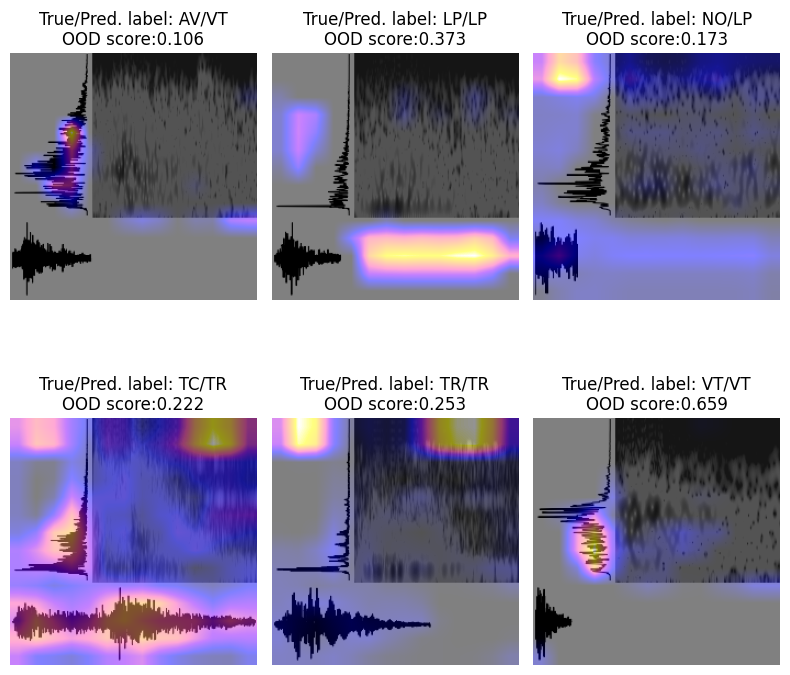

In [22]:
fig, axes = plt.subplots(2,3,figsize=(8,8))
for idx, pred in enumerate(predicted):
    i, j = divmod(idx, 3)
    target_layers = [model.features[43]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(pred)]
    grayscale_cam = cam(input_tensor=batch[idx].unsqueeze(0), targets=targets)
    cam_ = grayscale_cam[0, :]
    example_img = batch[idx].detach().cpu().numpy().transpose(1, 2, 0)
    example_img = np.mean(example_img, axis=2)
    example_img -= example_img.min()
    example_img /= example_img.max()
    example_img *= 255
    axes[i,j].imshow(example_img, cmap="gray")
    axes[i,j].imshow(cam_, cmap="gnuplot2", alpha=0.5)
    # plt.title(f"{context} | {correctness} | {clase_plot}")
    axes[i,j].axis("off")
    axes[i,j].set_title(f"True/Pred. label: {true_labels[idx]}/{labels[pred]}\nOOD score:{KNN_scores[idx]:.3f}")
plt.tight_layout()
    